# CDD_CNN_Transformer_best

This notebook contains the consolidated, best-practice multimodal CNN + Transformer training pipeline adapted from existing CDD_CNN_Transformer notebooks. It includes robust image loading (handles missing views), TF-IDF text features, metadata encoding, optional RadImageNet encoder with a small CNN fallback, feature caching, training and evaluation.

The notebook is organized into sections for reproducible experiment tracking, data loading, preprocessing, modeling, evaluation and saving artifacts.

In [18]:
# Full pipeline: imports, config, helpers, model, training

# Section 1: imports and configuration
import os
import json
import sys
import platform
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import (Input, Dense, Dropout, Conv2D, MaxPooling2D,
                                     GlobalAveragePooling2D, GlobalAveragePooling1D,
                                     TimeDistributed, Concatenate, Lambda)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, f1_score, accuracy_score, roc_auc_score
from tensorflow.keras.utils import to_categorical
from PIL import Image
import joblib


In [19]:

# Minimal CONFIG — edit paths and hyperparams as needed
CONFIG = {
    'image_dir_le': 'CDD-CESM/PKG - CDD-CESM/CDD-CESM/Low energy images of CDD-CESM',
    'image_dir_sub': 'CDD-CESM/PKG - CDD-CESM/CDD-CESM/Subtracted images of CDD-CESM',
    'json_dir': 'CDD-CESM/json_output',
    'excel_path': 'processed_metadata.csv',
    'img_size': (224, 224),
    'n_views': 8,
    'tfidf_max_features': 1000,
    'batch_size': 16,
    'epochs': 30,
    'seed': 42,
    'radimagenet_weights': 'weights/RadImageNet-DenseNet121_notop.h5',
    'save_features_dir': 'model',
    'features_names': ('X_img_train_feats.npy','X_img_val_feats.npy','X_img_test_feats.npy'),
    'model_ckpt': 'best_model_phase2.h5',
    'metrics_log': 'model_metrics_log.csv',
}

os.makedirs(CONFIG['save_features_dir'], exist_ok=True)
np.random.seed(CONFIG['seed'])


In [20]:

# Utilities

def load_metadata(excel_path):
    df = pd.read_csv(excel_path)
    df = df.dropna(subset=['Patient_ID', 'Pathology Classification/ Follow up'])
    df['Patient_ID'] = df['Patient_ID'].astype(str)
    print(f"Loaded metadata with {len(df)} entries.")
    return df


def load_texts(df, json_dir):
    texts = []
    for pid in df['Patient_ID']:
        path = os.path.join(json_dir, f"P{pid}.json")
        if os.path.exists(path):
            try:
                with open(path, encoding='utf-8') as f:
                    d = json.load(f)
                flat = []
                for v in d.values():
                    flat.extend(map(str, v) if isinstance(v, list) else [str(v)])
                texts.append(" ".join(flat))
            except Exception:
                texts.append("")
        else:
            texts.append("")
    print(f"Loaded {len(texts)} text entries.")
    return texts


def load_images_sequential_partial(patient_id, image_dir_le, image_dir_sub, img_size=(224,224), n_views=8):
    H, W = img_size
    print(f"Loading images for patient {patient_id}...")
    paths = [
        f"{image_dir_le}/P{patient_id}_L_DM_CC.jpg",
        f"{image_dir_le}/P{patient_id}_L_DM_MLO.jpg",
        f"{image_dir_sub}/P{patient_id}_L_CM_CC.jpg",
        f"{image_dir_sub}/P{patient_id}_L_CM_MLO.jpg",
        f"{image_dir_le}/P{patient_id}_R_DM_CC.jpg",
        f"{image_dir_le}/P{patient_id}_R_DM_MLO.jpg",
        f"{image_dir_sub}/P{patient_id}_R_CM_CC.jpg",
        f"{image_dir_sub}/P{patient_id}_R_CM_MLO.jpg",
    ]

    imgs = []
    found_any = False
    for p in paths[:n_views]:
        if os.path.exists(p):
            try:
                img = Image.open(p).convert('L').resize((W, H))
                arr = np.array(img, dtype=np.float32) / 255.0
                arr = arr[..., np.newaxis]
                found_any = True
            except Exception:
                arr = np.zeros((H, W, 1), dtype=np.float32)
        else:
            arr = np.zeros((H, W, 1), dtype=np.float32)
        imgs.append(arr)

    return np.stack(imgs, axis=0) if found_any else None


In [21]:

# Model pieces

def focal_loss(gamma=2., alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon())
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))
    return loss_fn


class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(embed_dim),
        ])
        self.ln1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.ln2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.do1 = Dropout(rate)
        self.do2 = Dropout(rate)

    def call(self, inputs, training=None):
        attn = self.att(inputs, inputs)
        attn = self.do1(attn, training=training)
        out1 = self.ln1(inputs + attn)
        ffn = self.ffn(out1)
        ffn = self.do2(ffn, training=training)
        return self.ln2(out1 + ffn)



In [22]:

from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D

def create_small_cnn_encoder(img_size=(224,224), output_dim=64):
    inp = Input(shape=(img_size[0], img_size[1], 1))
    x = Conv2D(32, 3, activation='relu', padding='same')(inp)
    x = MaxPooling2D(2)(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(output_dim, activation='relu')(x)
    return Model(inp, x)


def create_radimagenet_encoder(weight_path, img_size=(224,224), output_dim=64):
    try:
        base = DenseNet121(include_top=False, weights=None, input_shape=(img_size[0], img_size[1], 3))
        if os.path.exists(weight_path):
            base.load_weights(weight_path)
            base.trainable = False
            print('Loaded RadImageNet weights.')
        else:
            raise FileNotFoundError
        inp = Input(shape=(img_size[0], img_size[1], 1))
        x = Lambda(lambda img: tf.image.grayscale_to_rgb(img))(inp)
        x = preprocess_input(x)
        x = base(x, training=False)
        x = GlobalAveragePooling2D()(x)
        x = Dense(output_dim, activation='relu')(x)
        return Model(inp, x)
    except Exception:
        print('RadImageNet unavailable — using small CNN fallback.')
        return create_small_cnn_encoder(img_size=img_size, output_dim=output_dim)



In [23]:

def build_multimodal_model(img_feat_dim, meta_dim, text_dim, n_classes):
    img_feat_input = Input(shape=(img_feat_dim,), name='img_feat')
    meta_input = Input(shape=(meta_dim,), name='meta_input')
    text_input = Input(shape=(text_dim,), name='text_input')

    x_meta = Dense(64, activation='relu')(meta_input)
    x_text = Dense(64, activation='relu')(text_input)

    x = Concatenate()([img_feat_input, x_meta, x_text])
    x_seq = Lambda(lambda z: tf.expand_dims(z, axis=1))(x)
    x_seq = TransformerBlock(embed_dim=int(x.shape[-1]), num_heads=4, ff_dim=128)(x_seq)
    x = GlobalAveragePooling1D()(x_seq)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    out = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=[img_feat_input, meta_input, text_input], outputs=out, name='multimodal_phase2')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=focal_loss(), metrics=['accuracy'])
    return model


In [24]:

# Dataset preparation

def prepare_dataset(cfg=CONFIG):
    print('Preparing dataset...')
    df = load_metadata(cfg['excel_path'])
    texts = load_texts(df, cfg['json_dir'])

    sampled_df = df.sample(frac=0.8, random_state=cfg['seed'])
    sampled_patient_ids = sampled_df['Patient_ID'].tolist()

    images = []
    labels = []
    pids = []
    skipped = 0
    print(f"Loading images for {len(sampled_df)} patients...")
    for pid, label in zip(sampled_df['Patient_ID'], sampled_df['Pathology Classification/ Follow up']):
        seq = load_images_sequential_partial(pid, cfg['image_dir_le'], cfg['image_dir_sub'], cfg['img_size'], cfg['n_views'])
        if seq is not None:
            images.append(seq)
            labels.append(label)
            pids.append(pid)
        else:
            skipped += 1
            print(f'Skipped patient {pid} due to no images.')
    print(f'Loaded {len(images)} patients, skipped {skipped} due to no images.')

    common = list(set(pids) & set(sampled_patient_ids) & set(df['Patient_ID'].tolist()))
    image_dict = {pid: img for pid, img in zip(pids, images) if pid in common}
    label_dict = {pid: lab for pid, lab in zip(pids, labels) if pid in common}
    text_map = {pid: txt for pid, txt in zip(df['Patient_ID'], texts) if pid in common}
    meta_map = {pid: df[df['Patient_ID'] == pid].iloc[0] for pid in common}

    images_filtered = np.array([image_dict[pid] for pid in common])
    labels_filtered = [label_dict[pid] for pid in common]
    texts_filtered = [text_map[pid] for pid in common]
    meta_df_filtered = pd.DataFrame([meta_map[pid] for pid in common])

    vectorizer = TfidfVectorizer(max_features=cfg['tfidf_max_features'])
    text_feats = vectorizer.fit_transform(texts_filtered).toarray()

    numerical = meta_df_filtered.select_dtypes(include=['float', 'int']).columns.tolist()
    categorical = meta_df_filtered.select_dtypes(include=['object']).drop(columns=['Patient_ID', 'Pathology Classification/ Follow up']).columns.tolist()

    scaler = StandardScaler()
    encoder = OneHotEncoder(sparse_output=False)

    meta_num = scaler.fit_transform(meta_df_filtered[numerical]) if numerical else np.zeros((len(meta_df_filtered), 0))
    meta_cat = encoder.fit_transform(meta_df_filtered[categorical]) if categorical else np.zeros((len(meta_df_filtered), 0))
    meta_feats = np.concatenate([meta_num, meta_cat], axis=1) if (meta_num.size or meta_cat.size) else np.zeros((len(meta_df_filtered), 0))

    labels_encoded, label_names = pd.factorize(labels_filtered)
    labels_cat = to_categorical(labels_encoded)

    class_weights_vals = compute_class_weight(class_weight='balanced', classes=np.unique(labels_encoded), y=labels_encoded)
    class_weight_dict = dict(enumerate(class_weights_vals))

    X_img_temp, X_img_test, X_meta_temp, X_meta_test, X_txt_temp, X_txt_test, y_temp, y_test = train_test_split(
        images_filtered, meta_feats, text_feats, labels_cat, test_size=0.1, random_state=cfg['seed'])

    X_img_train, X_img_val, X_meta_train, X_meta_val, X_txt_train, X_txt_val, y_train, y_val = train_test_split(
        X_img_temp, X_meta_temp, X_txt_temp, y_temp, test_size=0.2, random_state=cfg['seed'])
    print(f'Train size: {X_img_train.shape[0]}, Val size: {X_img_val.shape[0]}, Test size: {X_img_test.shape[0]}')
    return (X_img_train, X_img_val, X_img_test,
            X_meta_train, X_meta_val, X_meta_test,
            X_txt_train, X_txt_val, X_txt_test,
            y_train, y_val, y_test,
            label_names, class_weight_dict)


def extract_image_features(X_img_train, X_img_val, X_img_test, cfg, feat_dim=64):
    feat_paths = [os.path.join(cfg['save_features_dir'], n) for n in cfg['features_names']]
    if all(os.path.exists(p) for p in feat_paths):
        print('Loading saved image features...')
        return [np.load(p) for p in feat_paths]

    cnn_encoder = create_radimagenet_encoder(cfg['radimagenet_weights'], img_size=cfg['img_size'], output_dim=feat_dim)

    seq_input = Input(shape=(cfg['n_views'], cfg['img_size'][0], cfg['img_size'][1], 1))
    td = TimeDistributed(cnn_encoder)(seq_input)
    td_pool = GlobalAveragePooling1D()(td)
    extractor = Model(seq_input, td_pool, name='feature_extractor')

    X_train_feats = extractor.predict(X_img_train, batch_size=cfg['batch_size'], verbose=1)
    X_val_feats = extractor.predict(X_img_val, batch_size=cfg['batch_size'], verbose=1)
    X_test_feats = extractor.predict(X_img_test, batch_size=cfg['batch_size'], verbose=1)

    np.save(feat_paths[0], X_train_feats)
    np.save(feat_paths[1], X_val_feats)
    np.save(feat_paths[2], X_test_feats)

    return X_train_feats, X_val_feats, X_test_feats


def train_and_evaluate(cfg=CONFIG):
    (X_img_train, X_img_val, X_img_test,
     X_meta_train, X_meta_val, X_meta_test,
     X_txt_train, X_txt_val, X_txt_test,
     y_train, y_val, y_test,
     label_names, class_weight_dict) = prepare_dataset(cfg)

    print('Dataset prepared. Train size:', X_img_train.shape[0])

    # show label distribution
    try:
        y_idx = np.argmax(y_train, axis=1)
        unique, counts = np.unique(y_idx, return_counts=True)
        plt.figure(figsize=(6,3))
        sns.barplot(x=[label_names[i] for i in unique], y=counts)
        plt.title('Train label distribution')
        plt.show()
    except Exception:
        pass

    X_train_feats, X_val_feats, X_test_feats = extract_image_features(X_img_train, X_img_val, X_img_test, cfg)

    model = build_multimodal_model(img_feat_dim=X_train_feats.shape[1], meta_dim=X_meta_train.shape[1] if X_meta_train.size else 0, text_dim=X_txt_train.shape[1], n_classes=y_train.shape[1])

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        ModelCheckpoint(cfg['model_ckpt'], monitor='val_loss', save_best_only=True),
        CSVLogger(cfg['metrics_log'])
    ]

    history = model.fit(
        [X_train_feats, X_meta_train, X_txt_train], y_train,
        validation_data=([X_val_feats, X_meta_val, X_txt_val], y_val),
        epochs=cfg['epochs'], batch_size=cfg['batch_size'],
        class_weight=class_weight_dict,
        callbacks=callbacks
    )

    preds = model.predict([X_test_feats, X_meta_test, X_txt_test])
    y_pred = np.argmax(preds, axis=1)
    y_true = np.argmax(y_test, axis=1)

    print(classification_report(y_true, y_pred, target_names=label_names))
    print('F1 (weighted):', f1_score(y_true, y_pred, average='weighted'))
    print('Accuracy:', accuracy_score(y_true, y_pred))
    try:
        print('ROC AUC:', roc_auc_score(y_test, preds, average='macro', multi_class='ovr'))
    except Exception:
        pass

    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

    return model, history


Notebook: to run training call train_and_evaluate(CONFIG)
Preparing dataset...
Loaded metadata with 2006 entries.
Loaded 2006 text entries.
Loading images for 1605 patients...
Loading images for patient 69...
Loading images for patient 184...
Loading images for patient 162...
Loading images for patient 304...
Loading images for patient 170...
Loading images for patient 191...
Loading images for patient 81...
Loading images for patient 16...
Loading images for patient 196...
Loading images for patient 185...
Loading images for patient 232...
Loading images for patient 30...
Loading images for patient 202...
Loading images for patient 18...
Loading images for patient 47...
Loading images for patient 294...
Loading images for patient 273...
Loading images for patient 119...
Loading images for patient 235...
Loading images for patient 174...
Loading images for patient 40...
Loading images for patient 311...
Loading images for patient 86...
Loading images for patient 89...
Loading images fo

/tmp/ipykernel_132351/648856965.py:51: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  labels_encoded, label_names = pd.factorize(labels_filtered)


Train size: 231, Val size: 58, Test size: 33
Dataset prepared. Train size: 231


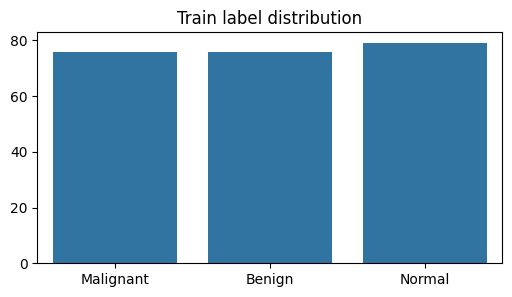

Loading saved image features...


2025-08-14 14:28:52.326230: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3329 - loss: 0.2593

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.3321 - loss: 0.2575 - val_accuracy: 0.2931 - val_loss: 0.1312
Epoch 2/30
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3017 - loss: 0.1690

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3022 - loss: 0.1694 - val_accuracy: 0.2931 - val_loss: 0.1261
Epoch 3/30
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3352 - loss: 0.1451

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3333 - loss: 0.1448 - val_accuracy: 0.4138 - val_loss: 0.1168
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4369 - loss: 0.1330 - val_accuracy: 0.5000 - val_loss: 0.1176
Epoch 5/30
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4015 - loss: 0.1310

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3946 - loss: 0.1306 - val_accuracy: 0.5172 - val_loss: 0.1168
Epoch 6/30
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3710 - loss: 0.1294

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3717 - loss: 0.1300 - val_accuracy: 0.4483 - val_loss: 0.1150
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3965 - loss: 0.1272 - val_accuracy: 0.6724 - val_loss: 0.1169
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3857 - loss: 0.1238 - val_accuracy: 0.3793 - val_loss: 0.1194
Epoch 9/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3755 - loss: 0.1264 - val_accuracy: 0.4483 - val_loss: 0.1198
Epoch 10/30
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3918 - loss: 0.1248

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3894 - loss: 0.1245 - val_accuracy: 0.5862 - val_loss: 0.1146
Epoch 11/30
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3666 - loss: 0.1223

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3675 - loss: 0.1221 - val_accuracy: 0.6552 - val_loss: 0.1133
Epoch 12/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3659 - loss: 0.1209 - val_accuracy: 0.5000 - val_loss: 0.1162
Epoch 13/30
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4643 - loss: 0.1138

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4658 - loss: 0.1139 - val_accuracy: 0.6207 - val_loss: 0.1120
Epoch 14/30
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4286 - loss: 0.1239

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4277 - loss: 0.1226 - val_accuracy: 0.6379 - val_loss: 0.1109
Epoch 15/30
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4227 - loss: 0.1214

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4224 - loss: 0.1213 - val_accuracy: 0.6034 - val_loss: 0.1100
Epoch 16/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4445 - loss: 0.1144

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4432 - loss: 0.1145 - val_accuracy: 0.6552 - val_loss: 0.1098
Epoch 17/30
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5140 - loss: 0.1148

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5072 - loss: 0.1149 - val_accuracy: 0.6552 - val_loss: 0.1096
Epoch 18/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4786 - loss: 0.1167

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4776 - loss: 0.1168 - val_accuracy: 0.6034 - val_loss: 0.1090
Epoch 19/30
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4381 - loss: 0.1219

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4467 - loss: 0.1210 - val_accuracy: 0.6034 - val_loss: 0.1073
Epoch 20/30
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5126 - loss: 0.1068

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5151 - loss: 0.1068 - val_accuracy: 0.6897 - val_loss: 0.1053
Epoch 21/30
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5081 - loss: 0.1135

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5058 - loss: 0.1132 - val_accuracy: 0.5345 - val_loss: 0.1043
Epoch 22/30
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5440 - loss: 0.1040

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5361 - loss: 0.1052 - val_accuracy: 0.6034 - val_loss: 0.1024
Epoch 23/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5665 - loss: 0.1065 - val_accuracy: 0.6897 - val_loss: 0.1031
Epoch 24/30
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5188 - loss: 0.1106

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5191 - loss: 0.1106 - val_accuracy: 0.6552 - val_loss: 0.0998
Epoch 25/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5796 - loss: 0.1100

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5767 - loss: 0.1100 - val_accuracy: 0.6379 - val_loss: 0.0990
Epoch 26/30
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5849 - loss: 0.1018

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5780 - loss: 0.1022 - val_accuracy: 0.6724 - val_loss: 0.0983
Epoch 27/30
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5921 - loss: 0.1007

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5820 - loss: 0.1009 - val_accuracy: 0.6552 - val_loss: 0.0937
Epoch 28/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5481 - loss: 0.1164 - val_accuracy: 0.7069 - val_loss: 0.0946
Epoch 29/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5699 - loss: 0.1021 - val_accuracy: 0.6207 - val_loss: 0.0978
Epoch 30/30
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5314 - loss: 0.0955

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5321 - loss: 0.0957 - val_accuracy: 0.6724 - val_loss: 0.0930
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step
              precision    recall  f1-score   support

   Malignant       0.86      0.55      0.67        11
      Benign       0.56      0.56      0.56         9
      Normal       0.59      0.77      0.67        13

    accuracy                           0.64        33
   macro avg       0.67      0.62      0.63        33
weighted avg       0.67      0.64      0.64        33

F1 (weighted): 0.6363636363636364
Accuracy: 0.6363636363636364
ROC AUC: 0.7892803324621506


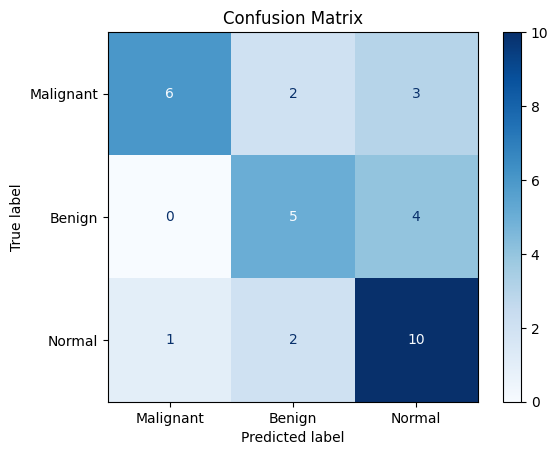

In [25]:

# Run when executed as script in notebook cell
if __name__ == '__main__':
    print('Notebook: to run training call train_and_evaluate(CONFIG)')
    # Uncomment to run training directly
    train_and_evaluate(CONFIG)
